In [2]:
import os
from chusai import FindFiles, CfgFormat, SampleSet, CsiFormatConvrt
from itertools import accumulate
import numpy as np

## 不同轮次的输入数据可放在不同文件夹中便于管理，这里用户可以自定义
PathSet = {0:"./TestData", 1:"./CompetitionData1", 2:"./CompetitionData2", 3:"./CompetitionData3", 4:"./CompetitionData4"}
PrefixSet = {0:"Test" , 1:"Round1", 2:"Round2", 3:"Round3", 4:"Round4"}

Ridx = 0 # 设置比赛轮次索引，指明数据存放目录。0:Test; 1: 1st round; 2: 2nd round ...
PathRaw = "./chusai_data/" + PathSet[Ridx]
PathOut = "./outputs/" + PathSet[Ridx]
Prefix = PrefixSet[Ridx]

# names= FindFiles(PathRaw) # 查找文件夹中包含的所有比赛/测试数据文件，非本轮次数据请不要放在目标文件夹中

# dirs = os.listdir(PathRaw)
na = '003'
dirs = os.listdir(PathRaw)
names = []  # 文件编号
files = []
for f in sorted(dirs):
    if f.endswith('.txt'):
        files.append(f)
for f in sorted(files):
    if f.find('CfgData') != -1 and f.endswith('.txt'):
        names.append(f.split('CfgData')[-1].split('.txt')[0])
        
# Np_total = 0
# for na in names[1:]:
#     Cfg = CfgFormat(PathRaw + '/' + Prefix + 'CfgData' + na + '.txt')
#     Np_total += Cfg['Np'].sum()
# print(Np_total)
Cfg = CfgFormat(PathRaw + '/' + Prefix + 'CfgData' + na + '.txt')

In [3]:
csi = np.genfromtxt(PathRaw + '/' + Prefix + 'InputData' + na + '.txt', dtype = float)
CSI = csi[:,0::2] + 1j* csi[:,1::2]

samp = SampleSet(na, Cfg, CSI)
del CSI
Nt = [0] + list(accumulate(samp.Cfg['Nt']))
CSI_s = samp.CSI_s # samp, Nrx, Ntx, Nsc, Nt
for ii in range(samp.Cfg['Nsamp']):
    CSI_s.append(CsiFormatConvrt(samp.CSI[Nt[ii]:Nt[ii+1],:], samp.Cfg['Nrx'],
                                        samp.Cfg['Ntx'], samp.Cfg['Nsc'], samp.Cfg['Nt'][ii]))


In [73]:
%matplotlib inline
from scipy.signal import savgol_filter
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
rx = 3
tx = 0

fs_ = samp.Cfg['Nt'] / samp.Cfg['Tdur']  # 采样频率
BPMresol = 0.1
resol = BPMresol / 60  # 要分辨出0.1BPM，需要的频率分辨率
Ndft_ = np.array(fs_ / resol, dtype=int)  # DFT点数

breathEnd = 1  # 呼吸最高频率 Hz
dftSize = int(breathEnd / resol)  # DFT宽度

psd_bg = np.zeros((samp.Cfg['Nsamp'], dftSize), dtype=complex)
psd_ = np.empty((samp.Cfg['Nsc'], samp.Cfg['Nsamp'], dftSize), dtype=complex)
psd_delta = np.empty((samp.Cfg['Nsc'], samp.Cfg['Nsamp'], dftSize), dtype=complex)
psd_amp = np.empty((samp.Cfg['Nsc'], samp.Cfg['Nsamp'], dftSize), dtype=complex)
psd_amp_ratio = np.empty((samp.Cfg['Nsc'], samp.Cfg['Nsamp'], dftSize), dtype=complex)

for sc in range(samp.Cfg['Nsc']):
    for ii in range(samp.Cfg['Nsamp']):

        psd_[sc][ii] = np.fft.fft(scale(savgol_filter(
            np.angle(CSI_s[ii][rx][tx][sc]), 8, 7)), Ndft_[ii])[:dftSize]
        psd_delta[sc][ii] = np.fft.fft(scale(savgol_filter(
            np.angle(CSI_s[ii][rx][tx][sc])-np.angle(CSI_s[ii][0][tx][sc]), 8, 7)), Ndft_[ii])[:dftSize]
        # psd_amp[sc][ii] = np.fft.fft(scale(savgol_filter(
        #     np.abs(CSI_s[ii][rx][tx][sc]), 8, 7)), Ndft_[ii])[:dftSize]
        # psd_amp_ratio[sc][ii] = np.fft.fft(scale(savgol_filter(
        #     np.abs(CSI_s[ii][0][tx][sc])/(np.abs(CSI_s[ii][rx][tx][sc])+1e-20), 8, 7)), Ndft_[ii])[:dftSize]
        psd_amp[sc][ii] = np.fft.fft(scale(savgol_filter(
            np.abs(CSI_s[ii][rx][tx][sc]), 8, 7)), Ndft_[ii])[:dftSize]
        psd_amp_ratio[sc][ii] = np.fft.fft(savgol_filter(
            np.abs(CSI_s[ii][0][tx][sc])/(np.abs(CSI_s[ii][rx][tx][sc])+1e-20), 8, 7), Ndft_[ii])[:dftSize]
        # 对实部虚部分别进行滤波
        # CSI_s_real = savgol_filter(np.real(CSI_s[ii][rx][tx][sc]), 8, 7)
        # CSI_s_imag = savgol_filter(np.imag(CSI_s[ii][rx][tx][sc]), 8, 7)
        # psd_[sc][ii] = np.fft.fft(scale(np.abs(CSI_s_real + 1j * CSI_s_imag)), Ndft_[ii])[:dftSize]

        # psd_[sc][ii] = np.fft.fft(scale(savgol_filter(
        #     np.angle(CSI_s[ii][rx][tx][sc]-CSI_s[ii][0][tx][sc]), 8, 7)), Ndft_[ii])[:dftSize]
        # psd_[sc][ii] = savgol_filter(np.abs(psd_[sc][ii]), 9, 3)
        # psd_[sc][ii] = np.fft.fft(scale(savgol_filter(np.abs(CSI_s[ii][rx][tx][sc]), 8, 7)), Ndft_[ii])[:dftSize]
        # psd_[sc][ii] = np.fft.fft(CSI_s[ii][rx][tx][sc], Ndft_[ii])[:dftSize]
        # plt.plot(np.abs(psd_[sc][ii]))
        psd_bg[ii] += psd_[sc][ii]
for ii in range(samp.Cfg['Nsamp']):
    psd_bg[ii] = savgol_filter(np.abs(psd_bg[ii] / samp.Cfg['Nsc']), 9, 3)
# psd_bg = np.mean(psd_, axis=(0,1))

/shared/conda/envs/bolt/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


0.43137696923176205
-1.5415667365772359


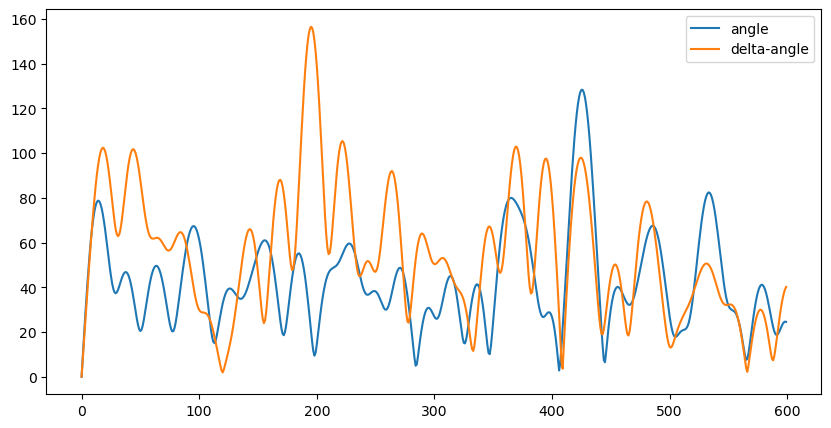

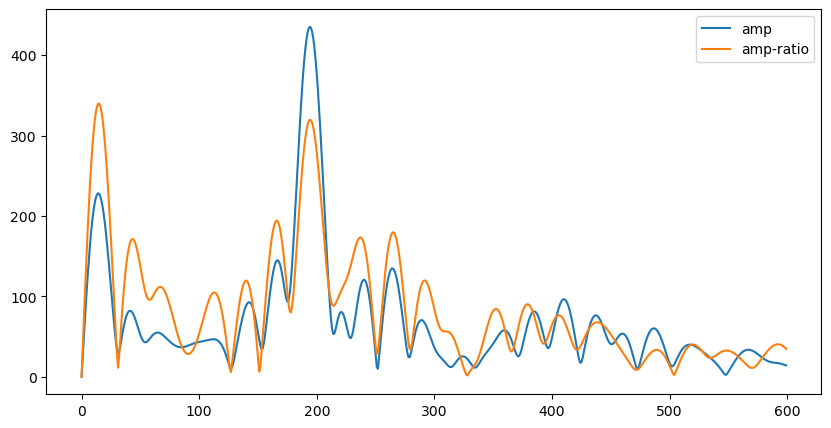

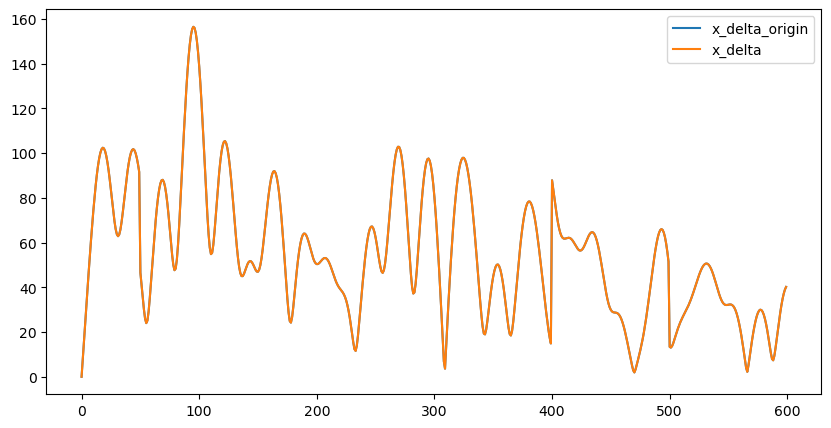

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, lfilter
from scipy.stats import kurtosis, skew
from scipy import signal

def zero_crossing_rate(x):
    return np.sum(np.abs(np.diff(np.sign(x)))) / len(x)
ii = 0
sc = 4
x = np.abs(psd_[sc][ii])
x_delta = np.abs(psd_delta[sc][ii])
x_amp = np.abs(psd_amp[sc][ii])
x_amp_ratio = np.abs(psd_amp_ratio[sc][ii])
freq = np.abs(np.fft.fft(x))
print(np.sum(freq[100:]) / np.sum(freq))
print(kurtosis(x[9:32]))
plt.figure(figsize=(10, 5))
plt.plot(x)
plt.plot(x_delta)
plt.legend(['angle', 'delta-angle'])
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(x_amp)
plt.plot(x_amp_ratio)
plt.legend(['amp', 'amp-ratio'])
plt.show()
# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, x)
# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(psd_bg[ii]))
# x = psd_bg[ii] - np.mean(psd_bg[ii])
# print(np.var(x[int(5/BPMresol):int(50/BPMresol)]) / np.max(x[int(5/BPMresol):int(50/BPMresol)]))
BPMrange = [5, 50]  # 5-50BPM
minBPM, maxBPM = BPMrange[0], BPMrange[1]
minIndex, maxIndex = int(minBPM / BPMresol), int(maxBPM / BPMresol)
# 将x的minIndex, maxIndex区间的值循环右移，右移长度为2/BPMresol个单位
shift = int(-10 / BPMresol)
x_delta[minIndex:maxIndex] = np.roll(x_delta[minIndex:maxIndex], shift)
x_delta_origin = x_delta.copy()
if shift > 0:
    shift_seq_left_ratio = x_delta[minIndex-1] / x_delta[minIndex]
    shift_seq_right_ratio = x_delta[minIndex+shift] / x_delta[minIndex+shift-1]
    seq_5060_left_ratio = x_delta[maxIndex-1] / x_delta[maxIndex]
    seq_5060_right_ratio = 1
    # 生成[shift_seq_left_ratio, shift_seq_right_ratio]区间的等比数列，长度为shift
    ratio_shift_seq = np.geomspace(shift_seq_left_ratio, shift_seq_right_ratio, shift)
    # 生成[seq_5060_left_ratio, seq_5060_right_ratio]区间的等比数列，长度为dftSize-maxIndex
    ratio_seq_5060 = np.geomspace(seq_5060_left_ratio, seq_5060_right_ratio, dftSize-maxIndex)
    x_delta[minIndex:minIndex+shift] *= ratio_shift_seq
    x_delta[maxIndex:] *= ratio_seq_5060

plt.figure(figsize=(10, 5))
plt.plot(x_delta_origin)
plt.plot(x_delta)
# plt.plot(x_delta)
plt.legend(['x_delta_origin', 'x_delta'])
plt.show()



In [ ]:

bpms = []
idx, _ = find_peaks(x, height=0.1, distance=3, width=3)
# 输出 idx 中大于5 小于50 的值
idx = idx[np.where((idx * BPMresol> 5 ) & (idx * BPMresol< 50 ))]
idx = idx[np.argsort(-x[idx])][:10]
var = np.var(np.abs(x[idx]))
bpm = idx * BPMresol
print(sc, bpm, var)
bpms.append(bpm)

0 [21 26 37 30 40 10 16 33 43 47] 1521.4376276202122 242.06402836282908
1 [21  9 24 16 12 28 37 44 34 40] 3414.527122942726 258.5512218265593
2 [21 24 10 29  6 15 38 43 34] 5207.739383455179 264.5050562668968
3 [21 24 29 10  6 33 36 41 49 45] 9479.602898492714 324.8245557866341
4 [22 29 10  6 19 40 33 36 46] 10302.928438751476 330.23418143615936
5 [22 25 29  6 10 19 15 34 49 38] 10678.519507277626 370.2617153398541
6 [22 29  8 12 40 15 33 43 47] 7300.883115939334 318.0387426656679
7 [22 25 29  8 38 19 43 33 13 48] 3705.171817289955 313.21271814198894
8 [43 25 30 38  8 20 33 16 13] 513.2477776051848 241.39046159401204
9 [21 11 24  7 16 37 43 29 33] 2488.198768624127 215.05618973727601
10 [22 19 10  6 29 15 44 48 36 32] 6867.238478573081 328.02471582680596
11 [22 25 10 19 29  6 15 46 42 39] 10730.272727576781 415.24759813534985
12 [22 19 29  8 12 34 37 46 43] 17693.974996822028 486.9033771560048
13 [22  8 25 19 29 15 40 46 43 34] 15045.647434137703 496.0062022527775
14 [22  8 25 19 29 34

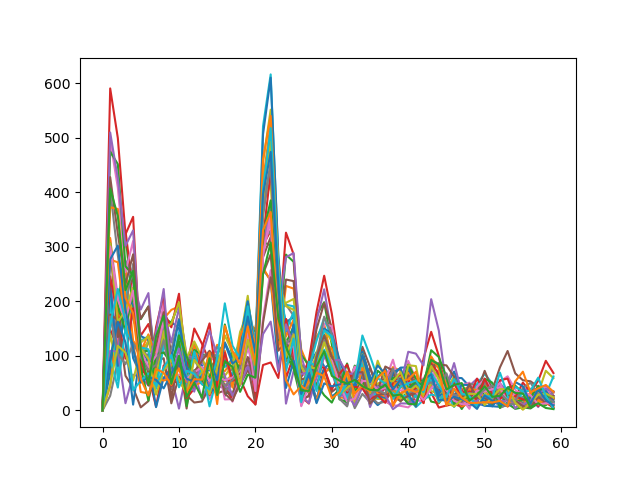

No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970
No such comm: 532a65229ab54f0e8f3c327a42879970


In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
# plt.plot(np.abs(CSI_s[0][0][0][0]))
# plt.plot(savgol_filter(np.abs(CSI_s[0][0][0][0]), 8, 7))

# for sc in range(samp.Cfg['Nsc']):
#     plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(psd_[sc][ii]))
# sc = 2
# for ii in range(samp.Cfg['Nsamp']):
#     plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(psd_[sc][ii]))

# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.angle(psd_bg))

bpms = []
vars_ = []
for sc in range(samp.Cfg['Nsc']):
    idx, _ = find_peaks(np.abs(psd_[sc][ii]), height=0.1, distance=3/BPMresol)
    # 输出 idx 中大于5 小于50 的值
    idx = idx[np.where((idx * BPMresol> 5 ) & (idx * BPMresol< 50 ))]
    idx = idx[np.argsort(-np.abs(psd_[sc][ii][idx]))][:10]
    var = np.var(np.abs(psd_[sc][ii][idx]))
    peaks = np.abs(psd_[sc][ii][int(5/BPMresol):int(50/BPMresol)])
    vars_.append(var)
    if var > 3000:
        plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(psd_[sc][ii]))
    bpm = idx * BPMresol
    print(sc, bpm, var, np.max(np.abs(psd_[sc][ii])))
    bpms.append(bpm)

[21 10 26 30 16 43 33 37  6 40 47]
[898 287 250  77  73  63  22   5   4   2   0]


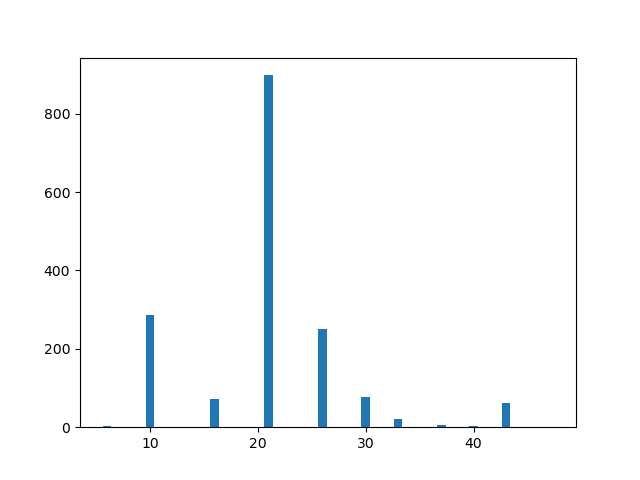

In [5]:
%matplotlib widget
ini = 0
centroids = bpms[ini] # 初始化质心
if len(centroids) == 0:
     ini = 1
     centroids = bpms[ini]
score = [20, 18, 2, 1, 0, 0, 0, 0, 0, 0]
if samp.Cfg['Np'][ii] > 1:
    score = [20, 18, 15, 1, 0, 0, 0, 0, 0, 0]
vote = np.array(score[:len(bpms[ini])])
clusters = [[bpms[ini][i]] for i in range(len(bpms[ini]))]
minvar = min(vars_)
maxvar = max(vars_)

for sc in range(ini, samp.Cfg['Nsc']):
    # if vars_[sc] < (maxvar - minvar) * 0.5 + minvar:
    #     continue
    for i in range(len(bpms[sc])):
        diff = np.abs(centroids - bpms[sc][i])
        # 若新的峰值与已有质心的距离都大于2BPM，则认为是新的质心
        if np.min(diff) > 3:
            centroids = np.append(centroids, bpms[sc][i])
            vote = np.append(vote, score[i])
            clusters.append([bpms[sc][i]])
        else:
            vote[np.argmin(diff)] += score[i]
            clusters[np.argmin(diff)].append(bpms[sc][i])
            # centroids[np.argmin(diff)] = np.mean(clusters[np.argmin(diff)])

plt.bar(centroids, vote)
centroids = centroids[np.argsort(-vote)]
print(centroids)
print(vote[np.argsort(-vote)])